# Comparing Total Gas Masses Between Analyses - LoCuSS High-$L_{\rm{X}}$

This notebook measures gas masses for the LoCuSS High-$L_{\rm{X}}$ sample, then compares them to the measurements from literature. While the focus of this work is the measurement of total galaxy cluster masses, comparing measured gas masses gives us an avenue to probe how similar our measurements of the baryon density of the clusters are to those from literature. Seeing as knowledge of the gas density profile feeds into the total gas mass, its important to know if we are consistent.

## Import Statements

In [1]:
import pandas as pd
import numpy as np
from astropy.units import Quantity, UnitConversionError, Unit
import matplotlib.pyplot as plt
from typing import Union, List
from shutil import rmtree
import os
from tqdm import tqdm

# This adds the directory above to the path, allowing me to import the common functions that I've written in
#  common.py - this just saves me repeating boring code and makes sure its all consistent
import sys
sys.path.insert(0, '..')
from common import locuss_colour, locuss_cosmo, direct_comparison_plot, find_lims, fit_comp

import xga
# This just sets the number of cores this analysis is allowed to use
xga.NUM_CORES = 100
# This is a bodge that will only work because xga_output in notebooks has already been defined, XGA
#  will be made to handle this more gracefully at some point
temp_dir = xga.OUTPUT
actual_dir = temp_dir.split('notebooks/')[0]+'notebooks/xga_output/'
xga.OUTPUT = actual_dir
xga.utils.OUTPUT = actual_dir
# As currently XGA will setup an xga_output directory in our current directory, I remove it to keep it all clean
if os.path.exists('xga_output'):
    rmtree('xga_output')
from xga.samples import ClusterSample
from xga.imagetools.psf import rl_psf
from xga.sourcetools.density import inv_abel_fitted_model, ann_spectra_apec_norm
from xga.models import BetaProfile1D, DoubleBetaProfile1D, KingProfile1D, SimpleVikhlininDensity1D
from xga.exceptions import ModelNotAssociatedError
from xga.xspec import single_temp_apec

## Reading in Sample File and Declaring XGA ClusterSample

This subsection involves reading in the sample files of the four test samples (described in [the sample properties notebook](sample_properties.ipynb)), then setting up separate XGA ClusterSample instances (see [the documentation](https://xga.readthedocs.io/en/latest/notebooks/tutorials/sources_samples.html) for an introduction to XGA source and sample objects.

We impose an additional cleaning step on each sample, where we make sure that (for each XMM observation initially associated with a source) at least 70% of a cluster's $R_{500}$ falls on that observation - if this requirement is not met then the observation is excluded. These requirements are set with the `clean_obs=True`, `clean_obs_reg='r500'`, and `clean_obs_threshold=0.7` arguments when a ClusterSample instance is declared.

### LoCuSS High-$L_{\rm{X}}$

The LoCuSS High-$L_{\rm{X}}$ sample was selected from ROSAT for its high luminosity clusters, and will again be a useful comparison as testing against various different analyses is beneficial in establishing the veracity of our new measurements.

In [2]:
locuss = pd.read_csv("../../sample_files/locuss_highlx_clusters.csv", dtype={'chandra_id': str, 'xmm_obsid': str})

In [3]:
# Reading out the relevant values into arrays just for ease of passing into the ClusterSample object
ra = locuss['ra'].values
dec = locuss['dec'].values
z = locuss['z'].values
n = locuss['name'].values
r500 = Quantity(locuss['r500'].values, 'kpc')
r2500 = Quantity(locuss['r2500'].values, 'kpc')


# Declaring the actual ClusterSample instance for the LoCuSS sample
locuss_srcs = ClusterSample(ra, dec, z, n, r500=r500, r2500=r2500, cosmology=locuss_cosmo, load_fits=True, 
                            use_peak=False, clean_obs=True, clean_obs_reg='r500', clean_obs_threshold=0.7)

Declaring BaseSource Sample:  36%|███████████████▊                            | 18/50 [00:10<00:22,  1.45it/s]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/base.py:90: UserWarning: Source ZwCl0949.6+5207 does not appear to have any XMM data, and will not be included in the sample.
  warn("Source {n} does not appear to have any XMM data, and will not be included in the "
Declaring BaseSource Sample:  46%|████████████████████▏                       | 23/50 [00:13<00:20,  1.33it/s]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/base.py:90: UserWarning: Source Abell1423 does not appear to have any XMM data, and will not be included in the sample.
  warn("Source {n} does not appear to have any XMM data, and will not be included in the "
Declaring BaseSource Sample:  54%|███████████████████████▊                    | 27/50 [00:15<00:11,  1.98it/s]/mnt/pact/dt237/code/PycharmProjects/XGA/xga/samples/base.py:90: UserWarning: Source Abell1682 does not appear to have any XMM data, and

## Running PSF Correction

In [4]:
rl_psf(locuss_srcs)

Generating products of type(s) image: 100%|███████████████████████████████████| 46/46 [00:02<00:00, 17.35it/s]


## Reading in literature data

### Gas masses from literature

In [5]:
loc_lit_gms = [locuss[locuss['name'] == n].iloc[0][['x_mg500', 'x_mg500_err', 'x_mg500_err']].values
               for n in locuss_srcs.names]
loc_lit_gm2500s = [locuss[locuss['name'] == n].iloc[0][['x_mg2500', 'x_mg2500_err', 'x_mg2500_err']].values
               for n in locuss_srcs.names]
loc_lit_gms = Quantity(loc_lit_gms, 'Msun')
loc_lit_gm2500s = Quantity(loc_lit_gm2500s, 'Msun')

### Conversion Temperatures

In [6]:
loc_conv_txs = []
    
for src in locuss_srcs:
    loc_conv_txs.append(locuss[locuss['name'] == src.name].iloc[0]['x_Tx500ce'])

loc_conv_txs = Quantity(loc_conv_txs, 'keV')

## Gas Density Profile Generation and Comparison to Literature - from $S_{B}$ Profiles

### Beta and King Profiles - out to 1.3$R_{500}$

In [7]:
demo_sb_mod = BetaProfile1D()
demo_sb_mod.info()
demo_sb_mod.par_priors

╒═════════════════╤═════════════════════════════════════════════════════════════════════════════╕
│ Beta Profile    │                                                                             │
╞═════════════════╪═════════════════════════════════════════════════════════════════════════════╡
│ DESCRIBES       │ Surface Brightness                                                          │
├─────────────────┼─────────────────────────────────────────────────────────────────────────────┤
│ UNIT            │ ct / (arcmin2 s)                                                            │
├─────────────────┼─────────────────────────────────────────────────────────────────────────────┤
│ PARAMETERS      │ beta, r_core, norm                                                          │
├─────────────────┼─────────────────────────────────────────────────────────────────────────────┤
│ PARAMETER UNITS │ , kpc, ct / (arcmin2 s)                                                     │
├─────────────────┼─

[{'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [   0., 2000.] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 3.] ct / (arcmin2 s)>, 'type': 'uniform'}]

In [8]:
loc_beta_13_dp = inv_abel_fitted_model(locuss_srcs, 'beta', 'mcmc', locuss_srcs.r500*1.3, 
                                       conv_temp=loc_conv_txs)

Running XSPEC Simulations: 100%|██████████████████████████████████████████████| 46/46 [00:14<00:00,  3.24it/s]
Fitting data, inverse Abel transforming, and measuring densities: 100%|███████| 46/46 [17:50<00:00, 23.28s/it]


In [9]:
demo_d_mod = KingProfile1D(y_unit=Unit("1 / cm^3"))
demo_d_mod.info()
demo_d_mod.par_priors

╒═════════════════╤═════════════════════════════════════════════════════════════════════════╕
│ King Profile    │                                                                         │
╞═════════════════╪═════════════════════════════════════════════════════════════════════════╡
│ DESCRIBES       │ Gas Density                                                             │
├─────────────────┼─────────────────────────────────────────────────────────────────────────┤
│ UNIT            │ 1 / cm3                                                                 │
├─────────────────┼─────────────────────────────────────────────────────────────────────────┤
│ PARAMETERS      │ beta, r_core, norm                                                      │
├─────────────────┼─────────────────────────────────────────────────────────────────────────┤
│ PARAMETER UNITS │ , kpc, 1 / cm3                                                          │
├─────────────────┼─────────────────────────────────────────

[{'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [   0., 2000.] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [ 0., 10.] 1 / cm3>, 'type': 'uniform'}]

In [10]:
with tqdm(desc="Fitting density model to LoCuSS profiles", total=len(loc_beta_13_dp)) as onwards:
    for dp in loc_beta_13_dp:
        if dp is not None:
            dp.fit('king', progress_bar=False)
        onwards.update(1)

Fitting density model to LoCuSS profiles: 100%|███████████████████████████████| 46/46 [25:53<00:00, 33.78s/it]


In [11]:
loc_beta_king_13_gm500 = []
loc_beta_king_13_gm2500 = []

with tqdm(desc="Calculating LoCuSS gas masses", total=len(loc_beta_13_dp)) as onwards:
    for dp in loc_beta_13_dp:
        if dp is not None:
            gm = dp.gas_mass("king", locuss_srcs[dp.src_name].r500)[0]
            loc_beta_king_13_gm500.append(gm)
            gm = dp.gas_mass("king", locuss_srcs[dp.src_name].r2500)[0]
            loc_beta_king_13_gm2500.append(gm)
        else:
            loc_beta_king_13_gm2500.append([np.NaN, np.NaN, np.NaN])
            loc_beta_king_13_gm500.append([np.NaN, np.NaN, np.NaN])
        onwards.update(1)               
        
loc_beta_king_13_gm500 = Quantity(loc_beta_king_13_gm500, 'Msun')
loc_beta_king_13_gm2500 = Quantity(loc_beta_king_13_gm2500, 'Msun')

Calculating LoCuSS gas masses: 100%|██████████████████████████████████████████| 46/46 [01:39<00:00,  2.16s/it]


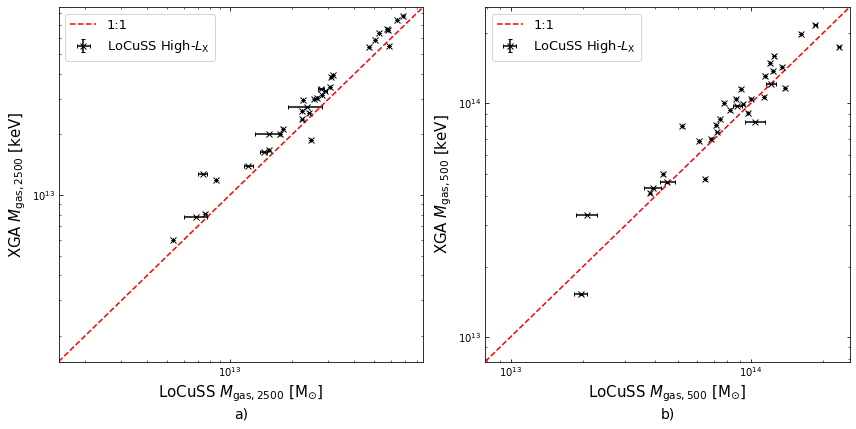

In [12]:
direct_comparison_plot([loc_lit_gm2500s, loc_lit_gms], [loc_beta_king_13_gm2500, loc_beta_king_13_gm500], 
                       [r"LoCuSS $M_{\rm{gas, 2500}}$ [M$_{\odot}$]", r"LoCuSS $M_{\rm{gas, 500}}$ [M$_{\odot}$]"], 
                       [r"XGA $M_{\rm{gas, 2500}}$ [keV]", r"XGA $M_{\rm{gas, 500}}$ [keV]"],
                       r"LoCuSS High-$L_{\rm{X}}$", (12, 6), ['log', 'log'], ['log', 'log'])
# savepath='../../outputs/figures/locussBLAH_comp.pdf'

### Double Beta and Simplified Vikhlinin Profiles - out to 1.3$R_{500}$

In [13]:
demo_sb_mod = DoubleBetaProfile1D()
demo_sb_mod.info()
demo_sb_mod.par_priors

╒═══════════════════════╤════════════════════════════════════════════════════════════════════════════╕
│ Double Beta Profile   │                                                                            │
╞═══════════════════════╪════════════════════════════════════════════════════════════════════════════╡
│ DESCRIBES             │ Surface Brightness                                                         │
├───────────────────────┼────────────────────────────────────────────────────────────────────────────┤
│ UNIT                  │ ct / (arcmin2 s)                                                           │
├───────────────────────┼────────────────────────────────────────────────────────────────────────────┤
│ PARAMETERS            │ beta_one, r_core_one, norm_one, beta_two, r_core_two, norm_two             │
├───────────────────────┼────────────────────────────────────────────────────────────────────────────┤
│ PARAMETER UNITS       │ , kpc, ct / (arcmin2 s), , kpc, ct / (arcmin2 s

[{'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [1.e+00, 2.e+03] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 3.] ct / (arcmin2 s)>, 'type': 'uniform'},
 {'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [1.e+00, 2.e+03] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 3.] ct / (arcmin2 s)>, 'type': 'uniform'}]

In [14]:
loc_dblbeta_13_dp = inv_abel_fitted_model(locuss_srcs, 'double_beta', 'mcmc', locuss_srcs.r500*1.3, 
                                       conv_temp=loc_conv_txs)

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/xspec/run.py:186: UserWarning: All XSPEC operations had already been run.
  warnings.warn("All XSPEC operations had already been run.")
Fitting data, inverse Abel transforming, and measuring densities:   0%|                | 0/46 [00:00<?, ?it/s]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1126.57163234  576.26939483 1079.69620792  885.48028552 1014.54383501
 1066.05868782]


Fitting data, inverse Abel transforming, and measuring densities:   7%|▌       | 3/46 [01:20<19:08, 26.72s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1387.34720801  591.3237186  1479.81502937 1319.68426879 1427.52670409
 1483.52202964]


Fitting data, inverse Abel transforming, and measuring densities:   9%|▋       | 4/46 [01:43<17:53, 25.55s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 829.87793848 1473.92093843 1433.39144691 1399.28693002 1455.57703532
 1551.52686504]


Fitting data, inverse Abel transforming, and measuring densities:  17%|█▍      | 8/46 [03:28<16:29, 26.04s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 353.7003784   272.1788117  1866.93218759 1743.83136587 1799.03411043
 1718.7166275 ]


Fitting data, inverse Abel transforming, and measuring densities:  20%|█▌      | 9/46 [03:56<16:34, 26.88s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [413.82510709 385.66680903 288.6250318  256.20917905 291.96750729
 368.06516222]


Fitting data, inverse Abel transforming, and measuring densities:  24%|█▋     | 11/46 [04:49<15:28, 26.52s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [147.17891989 417.38379082 345.26350165 195.94884808 181.78787744
 137.47466763]


Fitting data, inverse Abel transforming, and measuring densities:  28%|█▉     | 13/46 [05:42<14:22, 26.13s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1431.07792784  567.48019464 1466.45474392 1463.11882094 1527.02496788
 1375.71375818]
The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 342.04423125  884.96786494  852.74282722  753.65001006  849.9141368
 1067.62094448]


Fitting data, inverse Abel transforming, and measuring densities:  33%|██▎    | 15/46 [06:34<13:33, 26.24s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [551.60230326 530.54942914 372.88941914 382.37767779 427.14024991
 545.26124193]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [188.334563   273.98061723 708.07910079 265.29997519 266.90871618
 204.62420534]


Fitting data, inverse Abel transforming, and measuring densities:  35%|██▍    | 16/46 [06:59<12:51, 25.73s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 668.28050698  234.55396588 1749.2155312  1331.14667372 1379.31326046
 1535.27547361]


Fitting data, inverse Abel transforming, and measuring densities:  39%|██▋    | 18/46 [07:48<11:42, 25.08s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1522.25599579  477.36309068 2119.7646984   587.25456416  804.38814871
 2114.72161062]


Fitting data, inverse Abel transforming, and measuring densities:  48%|███▎   | 22/46 [09:44<11:15, 28.13s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1572.56580085  959.33846723 2490.68822012 2275.95369303 2226.71166896
 2491.62194434]


Fitting data, inverse Abel transforming, and measuring densities:  52%|███▋   | 24/46 [10:30<09:15, 25.26s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1575.50497595  700.73498077 1678.71353817 1073.24918297  966.65364804
 1676.5981667 ]
The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 850.28092678 1564.57745014 1583.41042028  899.46324328 1571.45780714
 1586.97625074]


Fitting data, inverse Abel transforming, and measuring densities:  57%|███▉   | 26/46 [11:27<09:09, 27.47s/it]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of Abell1758N's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  59%|████   | 27/46 [11:51<08:19, 26.28s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1948.54485888  197.36303348 2236.28695931  381.09153074  467.97134219
 2231.72438584]
The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 312.86961143  505.98693607 1246.6994682   934.56111945  496.92964949
  353.6762758 ]


Fitting data, inverse Abel transforming, and measuring densities:  72%|█████  | 33/46 [14:39<05:56, 27.45s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 909.70884681  729.39140971 2206.67863486 1082.77101911 1622.55102946
 2199.20639716]


Fitting data, inverse Abel transforming, and measuring densities:  74%|█████▏ | 34/46 [15:05<05:23, 27.00s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [951.13330158 747.80377918 920.11655248 829.78792128 887.63968191
 980.98034793]


Fitting data, inverse Abel transforming, and measuring densities:  78%|█████▍ | 36/46 [16:03<04:39, 27.98s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [234.12920828 396.39596586 445.49906002 408.32411371 449.07945885
 476.23068434]


Fitting data, inverse Abel transforming, and measuring densities:  93%|██████▌| 43/46 [19:24<01:24, 28.22s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [681.02045635 458.38060421 659.47786387 488.99967972 551.29401001
 707.79826878]


Fitting data, inverse Abel transforming, and measuring densities:  96%|██████▋| 44/46 [19:52<00:55, 27.99s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [666.22346779 530.06946912 711.07108222 535.105057   632.32013769
 727.35308102]


Fitting data, inverse Abel transforming, and measuring densities:  98%|██████▊| 45/46 [20:17<00:27, 27.06s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 827.121439    655.80759441 1319.13912559  974.8818834   662.79173892
 1214.49147511]


Fitting data, inverse Abel transforming, and measuring densities: 100%|███████| 46/46 [20:41<00:00, 27.00s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 412.57598197  306.16470248 1431.57003141 1053.64162009  682.85922589
 1357.19828441]


In [15]:
demo_d_mod = SimpleVikhlininDensity1D(y_unit=Unit("1 / cm^3"))
demo_d_mod.info()
demo_d_mod.par_priors

╒════════════════════════════════╤═══════════════════════════════════════════════════════════════════════╕
│ Simplified Vikhlinin Profile   │                                                                       │
╞════════════════════════════════╪═══════════════════════════════════════════════════════════════════════╡
│ DESCRIBES                      │ Gas Density                                                           │
├────────────────────────────────┼───────────────────────────────────────────────────────────────────────┤
│ UNIT                           │ 1 / cm3                                                               │
├────────────────────────────────┼───────────────────────────────────────────────────────────────────────┤
│ PARAMETERS                     │ beta, r_core, alpha, r_s, epsilon, norm                               │
├────────────────────────────────┼───────────────────────────────────────────────────────────────────────┤
│ PARAMETER UNITS                │ , 

[{'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [   0., 2000.] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 3.]>, 'type': 'uniform'},
 {'prior': <Quantity [   0., 2000.] kpc>, 'type': 'uniform'},
 {'prior': <Quantity [0., 5.]>, 'type': 'uniform'},
 {'prior': <Quantity [ 0., 10.] 1 / cm3>, 'type': 'uniform'}]

In [16]:
with tqdm(desc="Fitting density model to LoCuSS profiles", total=len(loc_dblbeta_13_dp)) as onwards:
    for dp in loc_dblbeta_13_dp:
        if dp is not None:
            dp.fit('simple_vikhlinin_dens', progress_bar=False)
        onwards.update(1)

Fitting density model to LoCuSS profiles:  11%|███▍                            | 5/46 [03:39<29:38, 43.37s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [141.47175138 320.05319391 649.28984034 128.46431798  57.66364743
 316.58817892]


Fitting density model to LoCuSS profiles:  13%|████▏                           | 6/46 [04:19<28:06, 42.16s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [105.07378995 102.09857725 872.48624921 106.69029247 122.7956433
  98.7502036 ]


Fitting density model to LoCuSS profiles:  17%|█████▌                          | 8/46 [05:50<27:46, 43.85s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [100.82762983 100.8209284  683.77215663  99.31805102 137.72770983
  99.263668  ]


Fitting density model to LoCuSS profiles:  22%|██████▋                        | 10/46 [07:20<26:42, 44.52s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 92.74275259  93.65964039 607.37508236  86.55786364  84.97377787
  84.48477012]


Fitting density model to LoCuSS profiles:  24%|███████▍                       | 11/46 [08:03<25:44, 44.13s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [2089.89711545 2376.21537907 2034.44559323 2138.76615205 1951.84366853
 2133.24203658]


Fitting density model to LoCuSS profiles:  28%|████████▊                      | 13/46 [09:30<24:05, 43.81s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [536.19476947 701.69533881 907.98561948 452.68198559 217.2138895
 772.72406891]


Fitting density model to LoCuSS profiles:  35%|██████████▊                    | 16/46 [11:40<21:27, 42.91s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1435.00865941 1420.36350124 1146.30095018 1585.39921882  806.18616739
 1394.6414545 ]


Fitting density model to LoCuSS profiles:  39%|████████████▏                  | 18/46 [13:05<19:51, 42.55s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [2051.1587041  2139.66057189  731.07518083 1453.54046843 2023.36716574
 1157.00788697]


Fitting density model to LoCuSS profiles:  46%|██████████████▏                | 21/46 [15:23<18:37, 44.72s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 94.26484692  95.22717424 827.24803404  95.1660418  123.90711251
  95.94190418]


Fitting density model to LoCuSS profiles:  52%|████████████████▏              | 24/46 [17:33<15:49, 43.15s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1333.88884403 1250.96993678  511.54902661 1305.68055735  513.55294479
  623.87567684]


Fitting density model to LoCuSS profiles:  72%|██████████████████████▏        | 33/46 [23:47<09:25, 43.47s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 570.6654045   538.13335054 2159.70760813  479.11929994  255.78251611
 1271.44649799]


Fitting density model to LoCuSS profiles:  74%|██████████████████████▉        | 34/46 [24:37<09:04, 45.34s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 68.41770974  75.70063062 872.04379822  91.64509806  87.24190321
  46.943427  ]


Fitting density model to LoCuSS profiles: 100%|███████████████████████████████| 46/46 [34:09<00:00, 44.55s/it]


In [17]:
loc_dblbeta_svikh_13_gm500 = []
loc_dblbeta_svikh_13_gm2500 = []
with tqdm(desc="Calculating LoCuSS gas masses", total=len(loc_dblbeta_13_dp)) as onwards:
    for dp in loc_dblbeta_13_dp:
        if dp is not None:
            gm = dp.gas_mass("simple_vikhlinin_dens", locuss_srcs[dp.src_name].r500)[0]
            loc_dblbeta_svikh_13_gm500.append(gm)
            gm = dp.gas_mass("simple_vikhlinin_dens", locuss_srcs[dp.src_name].r2500)[0]
            loc_dblbeta_svikh_13_gm2500.append(gm)
        else:
            loc_dblbeta_svikh_13_gm500.append([np.NaN, np.NaN, np.NaN])
            loc_dblbeta_svikh_13_gm2500.append([np.NaN, np.NaN, np.NaN])
            
        onwards.update(1)        

loc_dblbeta_svikh_13_gm500 = Quantity(loc_dblbeta_svikh_13_gm500, 'Msun')
loc_dblbeta_svikh_13_gm2500 = Quantity(loc_dblbeta_svikh_13_gm2500, 'Msun')

Calculating LoCuSS gas masses: 100%|██████████████████████████████████████████| 46/46 [07:30<00:00,  9.80s/it]


In [24]:
print("{s} out of {t} R2500 gas mass measurements produced a "\
      "result".format(s=np.isfinite(loc_dblbeta_svikh_13_gm2500[:, 0]).sum(), t=len(loc_dblbeta_svikh_13_gm2500)))
print("{s} out of {t} R500 gas mass measurements produced a "\
      "result".format(s=np.isfinite(loc_dblbeta_svikh_13_gm500[:, 0]).sum(), t=len(loc_dblbeta_svikh_13_gm500)))

45 out of 46 R2500 gas mass measurements produced a result
45 out of 46 R500 gas mass measurements produced a result


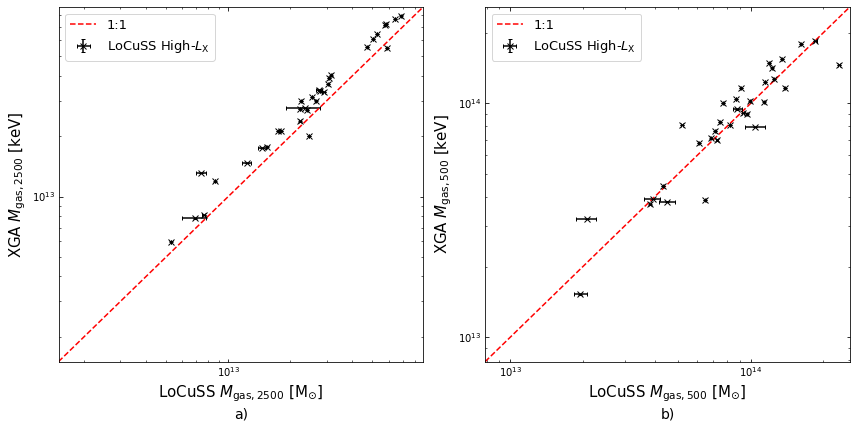

In [18]:
direct_comparison_plot([loc_lit_gm2500s, loc_lit_gms], [loc_dblbeta_svikh_13_gm2500, loc_dblbeta_svikh_13_gm500], 
                       [r"LoCuSS $M_{\rm{gas, 2500}}$ [M$_{\odot}$]", r"LoCuSS $M_{\rm{gas, 500}}$ [M$_{\odot}$]"], 
                       [r"XGA $M_{\rm{gas, 2500}}$ [keV]", r"XGA $M_{\rm{gas, 500}}$ [keV]"],
                       r"LoCuSS High-$L_{\rm{X}}$", (12, 6), ['log', 'log'], ['log', 'log'], 
                       savepath='../../outputs/figures/locuss_13r500_gmcomp_dblbeta_svikh.pdf')

In [19]:
loc_dblbeta_svikh_13_gm500.shape

(46, 3)

### Double Beta and Simplified Vikhlinin Profiles - out to 1.1$R_{500}$

In [20]:
loc_dblbeta_11_dp = inv_abel_fitted_model(locuss_srcs, 'double_beta', 'mcmc', locuss_srcs.r500*1.1, 
                                       conv_temp=loc_conv_txs)

/mnt/pact/dt237/code/PycharmProjects/XGA/xga/xspec/run.py:186: UserWarning: All XSPEC operations had already been run.
  warnings.warn("All XSPEC operations had already been run.")
Fitting data, inverse Abel transforming, and measuring densities:   2%|▏       | 1/46 [00:25<19:09, 25.55s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 868.91721711  779.10350069  922.3463498   987.05040724 1042.08753073
  945.68101656]


Fitting data, inverse Abel transforming, and measuring densities:   4%|▎       | 2/46 [00:53<19:51, 27.08s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [585.17036105 323.09302902 540.97601165 457.16622389 465.94163629
 547.17784826]


Fitting data, inverse Abel transforming, and measuring densities:   7%|▌       | 3/46 [01:18<18:45, 26.17s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1663.89593118  625.96551641 1764.80731535 1449.72865903 1624.18008147
 1727.47790443]


Fitting data, inverse Abel transforming, and measuring densities:   9%|▋       | 4/46 [01:41<17:26, 24.91s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 913.54020121 1797.27038256 1915.90818205 1807.23535672 1937.90483616
 2110.42855319]


Fitting data, inverse Abel transforming, and measuring densities:  11%|▊       | 5/46 [02:06<16:53, 24.72s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [293.82753511 444.56973104 176.4490648  131.56631292 178.07632164
 216.65482748]


Fitting data, inverse Abel transforming, and measuring densities:  13%|█       | 6/46 [02:31<16:34, 24.86s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [147.55634777 388.18358886 418.4722213  282.42615349 338.3271042
 440.32929095]


Fitting data, inverse Abel transforming, and measuring densities:  17%|█▍      | 8/46 [03:23<16:03, 25.35s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 283.07625622  553.39649001 1854.34716515 1845.31981401 1906.59377926
 1797.56446974]


Fitting data, inverse Abel transforming, and measuring densities:  28%|█▉     | 13/46 [05:34<14:07, 25.69s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1291.02743938  646.67989963 1343.09887756 1184.89420836 1270.16078071
 1208.21027714]


Fitting data, inverse Abel transforming, and measuring densities:  30%|██▏    | 14/46 [05:59<13:31, 25.36s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 344.65970059  940.47540852  929.9701914   849.72340655  968.62875896
 1195.55415682]


Fitting data, inverse Abel transforming, and measuring densities:  33%|██▎    | 15/46 [06:25<13:12, 25.57s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 929.34197041  945.44648761  851.48718429  923.00669837  992.93095335
 1013.36224747]


Fitting data, inverse Abel transforming, and measuring densities:  35%|██▍    | 16/46 [06:49<12:34, 25.16s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [240.26198579 268.74825575 591.0730799  181.09674543 188.98252481
 190.99768853]


Fitting data, inverse Abel transforming, and measuring densities:  37%|██▌    | 17/46 [07:15<12:15, 25.36s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 583.98506206  484.72972205 1715.10584891 1267.83698784 1351.48019661
 1497.76698303]


/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of Abell0781's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  39%|██▋    | 18/46 [07:38<11:31, 24.71s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 193.02835408 1044.26349607 2188.6681223  2444.60413123 2421.89845311
 2136.34221377]


Fitting data, inverse Abel transforming, and measuring densities:  48%|███▎   | 22/46 [09:32<11:03, 27.65s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 822.9944527   332.80451841 2056.04007503 1942.45622508 1765.96762188
 2041.350894  ]


Fitting data, inverse Abel transforming, and measuring densities:  50%|███▌   | 23/46 [09:57<10:21, 27.01s/it]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of RXCJ1212.3-1816's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  52%|███▋   | 24/46 [10:18<09:16, 25.29s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 636.67888836 1206.48038672 1973.38391191 1191.29928704 1516.3284497
 1964.89468257]


Fitting data, inverse Abel transforming, and measuring densities:  54%|███▊   | 25/46 [10:42<08:40, 24.77s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1110.96645075  981.96330495 2401.23064963 1215.67316756 1552.58969985
 2366.3493261 ]


Fitting data, inverse Abel transforming, and measuring densities:  57%|███▉   | 26/46 [11:12<08:50, 26.52s/it]/its/home/dt237/.conda/envs/dev_xga/lib/python3.8/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/mnt/pact/dt237/code/PycharmProjects/XGA/xga/sourcetools/density.py:531: UserWarning: One or more of the quantities passed to the init of Abell1758N's density profile has a NaN or Inf value in it.
  warn("One or more of the quantities passed to the init of {}'s density profile has a NaN or Inf value"
Fitting data, inverse Abel transforming, and measuring densities:  59%|████   | 27/46 [11:36<08:04, 25.52s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 808.96760759  593.78189087 2110.36747304 1039.88783624  810.91892745
 2110.1322054 ]


Fitting data, inverse Abel transforming, and measuring densities:  61%|████▎  | 28/46 [12:02<07:42, 25.68s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 763.88901085  826.56853467 1457.1204621  1259.27221952 1051.35481047
 1054.97559048]


Fitting data, inverse Abel transforming, and measuring densities:  72%|█████  | 33/46 [14:16<05:41, 26.25s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 748.3603324   938.39235675 1877.26557962 1307.1251512  1237.38498297
 1885.60423526]


Fitting data, inverse Abel transforming, and measuring densities:  76%|█████▎ | 35/46 [15:07<04:45, 25.93s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1159.58325832  857.58661406 1092.49158441 1174.1387727  1216.64347902
 1102.18182918]


Fitting data, inverse Abel transforming, and measuring densities:  78%|█████▍ | 36/46 [15:36<04:27, 26.76s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [ 523.01787196  752.09947196  962.14737352  713.38571132  815.55905751
 1001.02874241]


Fitting data, inverse Abel transforming, and measuring densities:  85%|█████▉ | 39/46 [16:59<03:11, 27.37s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [591.6096414  618.01825523 647.98337767 546.08097008 625.37604133
 658.6371019 ]


Fitting data, inverse Abel transforming, and measuring densities:  93%|██████▌| 43/46 [18:46<01:19, 26.52s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1140.34087397  733.2109152  1225.15072449 1177.57825531 1187.72547823
 1209.81012532]


Fitting data, inverse Abel transforming, and measuring densities:  96%|██████▋| 44/46 [19:12<00:52, 26.35s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [543.24544658 514.78870755 628.15862883 342.93110527 515.92536023
 678.84277343]


Fitting data, inverse Abel transforming, and measuring densities:  98%|██████▊| 45/46 [19:36<00:25, 25.63s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [1194.86745625 1245.72860815 2026.98966418 1585.30002938 1655.80587463
 1997.42294983]


Fitting data, inverse Abel transforming, and measuring densities: 100%|███████| 46/46 [20:00<00:00, 26.09s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 400;
tau: [295.00946139 609.99267867 712.71083262 418.55918378 482.82871429
 598.76568761]


In [21]:
with tqdm(desc="Fitting density model to LoCuSS profiles", total=len(loc_dblbeta_11_dp)) as onwards:
    for dp in loc_dblbeta_11_dp:
        if dp is not None:
            dp.fit('simple_vikhlinin_dens', progress_bar=False)
        onwards.update(1)

Fitting density model to LoCuSS profiles:   2%|▋                               | 1/46 [00:42<32:04, 42.77s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [112.39589498 155.68153206 998.75611613 117.75514712 116.25562708
 385.39003636]


Fitting density model to LoCuSS profiles:  13%|████▏                           | 6/46 [04:12<27:18, 40.97s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 112.40574983  108.6818176  1045.1901744   114.59169304  123.79438703
   97.92735628]


Fitting density model to LoCuSS profiles:  22%|██████▋                        | 10/46 [07:07<25:52, 43.14s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 83.37604543  89.12569434 812.94112101  81.57874525  82.85912961
  91.22691397]


Fitting density model to LoCuSS profiles:  24%|███████▍                       | 11/46 [07:49<24:54, 42.69s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [2382.72151576 2563.3977546  1306.48313883 2019.61682759 2322.4897377
 1369.03980857]


Fitting density model to LoCuSS profiles:  28%|████████▊                      | 13/46 [09:13<23:18, 42.39s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [327.99523908 475.88830489 840.35287487 236.51157227 177.49563905
 575.91688342]


Fitting density model to LoCuSS profiles:  33%|██████████                     | 15/46 [10:38<21:46, 42.13s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [107.71950485 117.3278767  883.72304539 109.20718877 115.37557927
 114.52490989]


Fitting density model to LoCuSS profiles:  35%|██████████▊                    | 16/46 [11:17<20:42, 41.40s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1053.92822457 1126.20979896  382.97453293 1174.28955481  431.19559745
  388.57417113]


Fitting density model to LoCuSS profiles:  41%|████████████▊                  | 19/46 [12:44<14:40, 32.61s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 86.59890319  93.28140713 655.97607425  85.58578166  84.02214353
  95.89375752]


Fitting density model to LoCuSS profiles:  61%|██████████████████▊            | 28/46 [17:59<09:10, 30.60s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 98.43799632 101.08923652 890.44410259 111.01652623 113.74779113
 105.17593432]


Fitting density model to LoCuSS profiles:  72%|██████████████████████▏        | 33/46 [21:43<08:55, 41.19s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [1837.06273637 1940.37220712  575.94310801 1734.33292319 1706.63332504
  991.28844216]


Fitting density model to LoCuSS profiles:  74%|██████████████████████▉        | 34/46 [22:31<08:37, 43.09s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 65.8356846   74.131192   634.29062049  80.91754186  82.13909145
  37.53315661]


Fitting density model to LoCuSS profiles:  76%|███████████████████████▌       | 35/46 [23:16<08:00, 43.72s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [537.57949227 855.97525346 842.99584508 263.39761797 158.00382779
 909.15325372]


Fitting density model to LoCuSS profiles:  93%|████████████████████████████▉  | 43/46 [29:32<02:16, 45.45s/it]

The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 600;
tau: [ 703.52828317  966.60072516 1158.55897874  499.41713332  200.9607534
 1119.37247168]


Fitting density model to LoCuSS profiles: 100%|███████████████████████████████| 46/46 [31:43<00:00, 41.37s/it]


In [22]:
loc_dblbeta_svikh_11_gm500 = []
loc_dblbeta_svikh_11_gm2500 = []
with tqdm(desc="Calculating LoCuSS gas masses", total=len(loc_dblbeta_11_dp)) as onwards:
    for dp in loc_dblbeta_11_dp:
        if dp is not None:
            gm = dp.gas_mass("simple_vikhlinin_dens", locuss_srcs[dp.src_name].r500)[0]
            loc_dblbeta_svikh_11_gm500.append(gm)
            gm = dp.gas_mass("simple_vikhlinin_dens", locuss_srcs[dp.src_name].r2500)[0]
            loc_dblbeta_svikh_11_gm2500.append(gm)
        else:
            loc_dblbeta_svikh_11_gm500.append([np.NaN, np.NaN, np.NaN])
            loc_dblbeta_svikh_11_gm2500.append([np.NaN, np.NaN, np.NaN])
            
        onwards.update(1)        

loc_dblbeta_svikh_11_gm500 = Quantity(loc_dblbeta_svikh_11_gm500, 'Msun')
loc_dblbeta_svikh_11_gm2500 = Quantity(loc_dblbeta_svikh_11_gm2500, 'Msun')

Calculating LoCuSS gas masses: 100%|██████████████████████████████████████████| 46/46 [07:11<00:00,  9.38s/it]


In [25]:
print("{s} out of {t} R2500 gas mass measurements produced a "\
      "result".format(s=np.isfinite(loc_dblbeta_svikh_11_gm2500[:, 0]).sum(), t=len(loc_dblbeta_svikh_11_gm2500)))
print("{s} out of {t} R500 gas mass measurements produced a "\
      "result".format(s=np.isfinite(loc_dblbeta_svikh_11_gm500[:, 0]).sum(), t=len(loc_dblbeta_svikh_11_gm500)))

43 out of 46 R2500 gas mass measurements produced a result
43 out of 46 R500 gas mass measurements produced a result


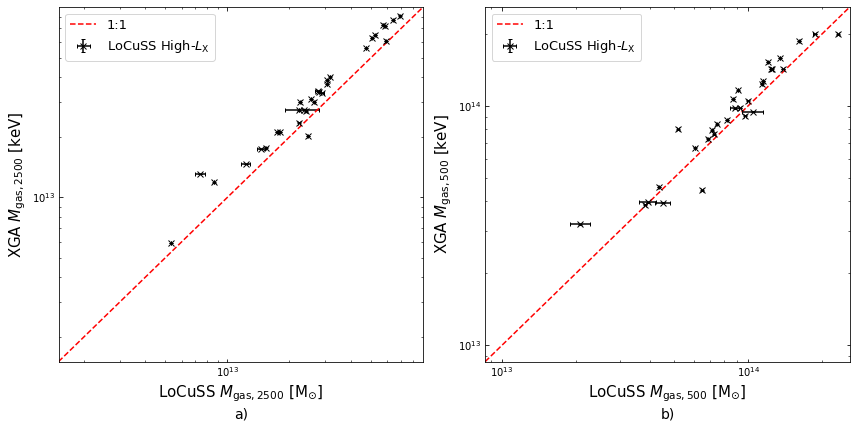

In [23]:
direct_comparison_plot([loc_lit_gm2500s, loc_lit_gms], [loc_dblbeta_svikh_11_gm2500, loc_dblbeta_svikh_11_gm500], 
                       [r"LoCuSS $M_{\rm{gas, 2500}}$ [M$_{\odot}$]", r"LoCuSS $M_{\rm{gas, 500}}$ [M$_{\odot}$]"], 
                       [r"XGA $M_{\rm{gas, 2500}}$ [keV]", r"XGA $M_{\rm{gas, 500}}$ [keV]"],
                       r"LoCuSS High-$L_{\rm{X}}$", (12, 6), ['log', 'log'], ['log', 'log'])
# savepath='../../outputs/figures/locussBLAH_comp.pdf'